# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [11]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


Sample of the dog and human images:


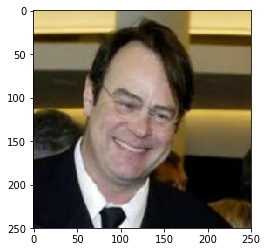

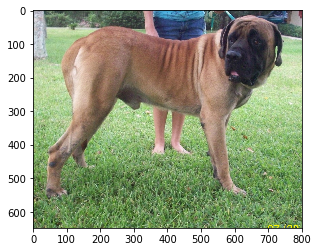

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

print("Sample of the dog and human images:")
img = Image.open(human_files[0])
plt.imshow(img)
plt.show()

img = Image.open(dog_files[0])
plt.imshow(img)
plt.show()

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


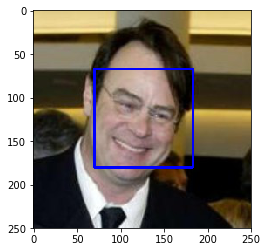

In [13]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [15]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [16]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_human = 0
num_dogs = 0
for path in human_files_short:
    if(face_detector(path)):
        # If the result is false
        num_human += 1

for path in dog_files_short:
    if(face_detector(path)):
        
        # If the result is false
        num_dogs += 1

print("Percentage of the human face Detection:",num_human)  
print("Percentage of the dog face Detection:",num_dogs)  

Percentage of the human face Detection: 98
Percentage of the dog face Detection: 17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [30]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
VGG16
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
#if use_cuda:
#    print("GPU is available")
#    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

### https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch. The above source is used to determine the size of the tensor accepted by the pytorch VGG16. 

In [18]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    
    
    # Normailize input images

    transformed_data = transforms.Compose([
                        transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()])
    
    # Apply the transformation
    image = transformed_data(image)

    image = image.unsqueeze(0)

    # Variables is the requirement by pytorch
    image = Variable(image)
    
    # Returns a Tensor
    predict = VGG16(image)
    predict = predict.data.numpy().argmax()
    ## Return the *index* of the predicted class for that image
    return predict
    

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    output = VGG16_predict(img_path)
    
    if output >= 151 and output <= 268:
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
1. In human files the percentage of misclassification is 2 %
2. In dog files there is 97% accuracy

In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

count_human = 0.0
count_dog = 0.0
print("before_check")
#Total number of images
img_count = len(human_files_short)

for i in range(0, img_count):
    human_path = human_files_short[i]
    dog_path = dog_files_short[i]
    
    if face_detector(human_path) == True:
        count_human += 1
    if dog_detector(dog_path) == True:
        count_dog += 1

print('VGG-16 Prediction')
print('The percentage of the detected humans - Humans: {0:.0%}'.format(count_human / img_count))
print('The percentage of the detected dog - Dogs: {0:.0%}'.format(count_dog / img_count))

before_check
VGG-16 Prediction
The percentage of the detected humans - Humans: 98%
The percentage of the detected dog - Dogs: 97%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [21]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20                    
num_workers = 0

data_dir = '/data/dog_images/' 
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

#Here the augmentation of the data is done using RandomHorizontalFlip()
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
                  }
# Create the loaders for the image
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

training_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
testing_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

# Here the image loader is constructed using the training_loader, validation_loader, testing_loader
loaders_scratch  = {
    'train': training_loader,
    'valid': validation_loader,
    'test': testing_loader
}
loaders_scratch

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdf4812c9b0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fdf4812c940>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fdf4812c9e8>}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
#### a) My code resizes the data to 224 X 224. The reason for this decision
        The images when resized will all have same sizes, and will occupy lesser memory than when it is original image.
####      The resize is performed using the Resize() method.
#### b) Yes the dataset is augmented since, augmentation provides more randomized dataset for training. This has 2 advantages:
        1.Possible overfitting of the model is avoided. This happens mainly if the photos are taken at different angles(horizontal) etc. 
        2. Provides the randomness to the dataset. This helps in training the model.
####      The augmentation is carried out using the RandomHorizontalFlip() method.
      
   

In [32]:
# Installing the torchsummary package to get the good summary

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("Installed")
install("torchsummary")

Installed


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Total number of the dog breeds
num_breeds = 133
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.convolution1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.convolution2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.convolution3 = nn.Conv2d(64, 128, 3, padding=1)

        # MaxPool2d
        self.pool = nn.MaxPool2d(2, 2)
        
        # The fully connected layers
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_breeds) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        ## Define forward behavior
        # In this function the relu activation method is used. This is one of the most common choices.
        x = F.relu(self.convolution1(x))              # First 
        x = self.pool(x)
        x = F.relu(self.convolution2(x))
        x = self.pool(x)
        x = F.relu(self.convolution3(x))
        x = self.pool(x)
        
        # Get the required shape by flattening
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)

        return x


#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    summary(model_scratch.cuda(),(3, 224, 224))
else:
    summary(model_scratch,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
         MaxPool2d-6            [-1, 128, 7, 7]               0
           Dropout-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 133]          66,633
Total params: 3,296,381
Trainable params: 3,296,381
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.60
Params size (MB): 12.57
Estima

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

#### First of all I would like to mention the blogs i used to cement my understanding of this in addition to the udacity course vedios. Going through these blogs gave me a solid understanding  of the CNN architecture(in addition to udacity material :) ).
https://missinglink.ai/guides/tensorflow/tensorflow-conv2d-layers-practical-guide/
#### Also for choosing between the maxpooling and average pooling, I went throgh the Answers on this Quora question
https://www.quora.com/What-is-the-benefit-of-using-average-pooling-rather-than-max-pooling



Now coming to the architecture the steps taken are as follows:

1. There are 3 convolution layers with the following architecture
    1. Convolution Layer1 -> In-channel:3  Out-channel:32  Kernel Size:3 stride:2 Padding:1
    2. Convolution Layer2 -> In-channel:32  Out-channel:64  Kernel Size:3 stride:2 Padding:1
    3. Convolution Layer3 -> In-channel:64  Out-channel:128  Kernel Size:3 Padding:1
2. Maxpooling is applied with the Kernel Size:2 Stride:2
3. 2 Fully-Connected Layers for the purpose of classifying the breed.
4. Drop-out of 0.3 is applied to make sure there is no overfitting
5. The activation function selected is ReLU activation function. This is applied to all the convolution layers.
6. Learning rate is set as 0.05 as 0.001 gave following test result.

Test Loss: 4.074241


Test Accuracy: 10% (91/836)

#### Explanation:
After a fair amount of research on the material mentioned above, I decided on the 3 convolution-layer network. 
Both of the first 2 layers have the same kernel size of 3 and stride of 2. This is used to reduce the size of the image by 2.
To downsize the image further the maxpooling layer is introduced after the 2 convolution layers. After the image is passed through the final convolution layer, the maxpooling is done again. As a result of this the image is downsized by the factor of 32 and depth of 128. Now there was a bit of confusion on what or if the dropout is needed? After going through some blogs, including useful one below
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
it was decided to put the dropout layer of 0.3. This saves the model from the issues of overfitting.
The Fully-Connected layers are introduced finally to make sure the classification of the dog breeds are taking place.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [37]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()
### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [38]:
training_loss_values = []
validation_loss_values = []
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            training_loss_values.append(train_loss)
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            validation_loss_values.append(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy


Epoch 1, Batch 1 loss: 4.907777
Epoch 1, Batch 101 loss: 4.886895
Epoch 1, Batch 201 loss: 4.882206
Epoch 1, Batch 301 loss: 4.873921
Epoch: 1 	Training Loss: 4.869000 	Validation Loss: 4.790068
Validation loss decreased (inf --> 4.790068).  Saving model ...
Epoch 2, Batch 1 loss: 4.744042
Epoch 2, Batch 101 loss: 4.799375
Epoch 2, Batch 201 loss: 4.789945
Epoch 2, Batch 301 loss: 4.765862
Epoch: 2 	Training Loss: 4.757970 	Validation Loss: 4.636396
Validation loss decreased (4.790068 --> 4.636396).  Saving model ...
Epoch 3, Batch 1 loss: 4.655332
Epoch 3, Batch 101 loss: 4.623887
Epoch 3, Batch 201 loss: 4.631793
Epoch 3, Batch 301 loss: 4.626698
Epoch: 3 	Training Loss: 4.621898 	Validation Loss: 4.475170
Validation loss decreased (4.636396 --> 4.475170).  Saving model ...
Epoch 4, Batch 1 loss: 4.420427
Epoch 4, Batch 101 loss: 4.587986
Epoch 4, Batch 201 loss: 4.582601
Epoch 4, Batch 301 loss: 4.570885
Epoch: 4 	Training Loss: 4.566297 	Validation Loss: 4.432703
Validation loss de

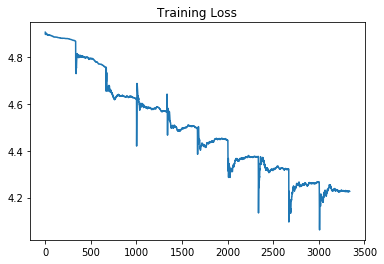

In [45]:
plt.title("Training Loss")
plt.plot(training_loss_values)

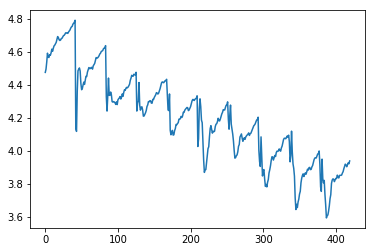

In [40]:
plt.plot(validation_loss_values)

In [46]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%. 

Test Loss: 3.987379


Test Accuracy: 10% (85/836)


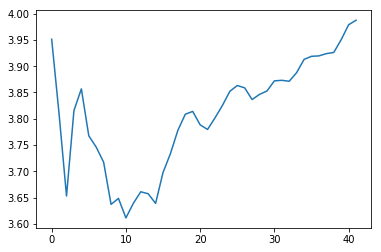

In [79]:
test_loss_values = []
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        test_loss_values.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


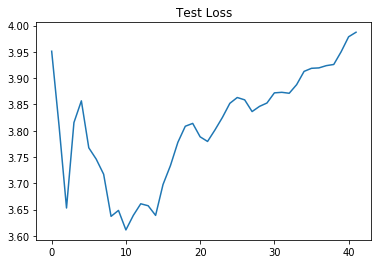

In [95]:
plt.title("Test Loss")
plt.plot(test_loss_values)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [49]:
## TODO: Specify data loaders

# I would like to copy the data loaders from the previous step.
loaders_transfer = loaders_scratch.copy() 


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [50]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133, bias=True)    
fc_parameters = model_transfer.fc.parameters()
#model_transfer.summary

In [51]:
for param in fc_parameters:
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()
    #print(model_transfer)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
#### First of all I would like to credit this beautiful article written by Raghav, which details the different methods. A table which compares each architecture is also given at the end of the article. I observed the ResNet (I originally thought about the VGG16 after looking into it in one of the other blogs. ) has a less error rate of ~3.6- 4% compared to the VGG16 model. Since this problem asks for an accuracy of atleast 60% I assumed i could do better with ResNet. 

Link of the Article.
https://medium.com/@RaghavPrabhu/cnn-architectures-lenet-alexnet-vgg-googlenet-and-resnet-7c81c017b848

Another reason i preffered this model is, I thought that since the model skips one or sometimes more than one layers. This may help to address the overfitting issue.

So lets try out the ResNet network! :)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [52]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [54]:
transfer_learning_training_loss = []
transfer_learning_validation_loss = []
# train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            transfer_learning_training_loss.append(train_loss)
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            transfer_learning_validation_loss.append(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch 1, Batch 1 loss: 4.956972
Epoch 1, Batch 101 loss: 4.872711
Epoch 1, Batch 201 loss: 4.834630
Epoch 1, Batch 301 loss: 4.799985
Epoch: 1 	Training Loss: 4.788956 	Validation Loss: 4.608617
Validation loss decreased (inf --> 4.608617).  Saving model ...
Epoch 2, Batch 1 loss: 4.593644
Epoch 2, Batch 101 loss: 4.635313
Epoch 2, Batch 201 loss: 4.606915
Epoch 2, Batch 301 loss: 4.580008
Epoch: 2 	Training Loss: 4.570275 	Validation Loss: 4.365753
Validation loss decreased (4.608617 --> 4.365753).  Saving model ...
Epoch 3, Batch 1 loss: 4.479635
Epoch 3, Batch 101 loss: 4.444258
Epoch 3, Batch 201 loss: 4.413449
Epoch 3, Batch 301 loss: 4.385547
Epoch: 3 	Training Loss: 4.375004 	Validation Loss: 4.123552
Validation loss decreased (4.365753 --> 4.123552).  Saving model ...
Epoch 4, Batch 1 loss: 4.200927
Epoch 4, Batch 101 loss: 4.229105
Epoch 4, Batch 201 loss: 4.219114
Epoch 4, Batch 301 loss: 4.197605
Epoch: 4 	Training Loss: 4.189966 	Validation Loss: 3.904004
Validation loss de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

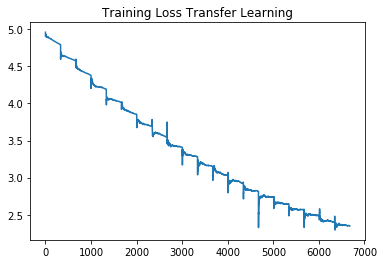

In [93]:
plt.title("Training Loss Transfer Learning")
plt.plot(transfer_learning_training_loss)

In [58]:
summary(model_transfer,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [88]:
test_loss_transfer = []
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy 
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        
        #data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        test_loss_transfer.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label 
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.811168


Test Accuracy: 72% (610/836)


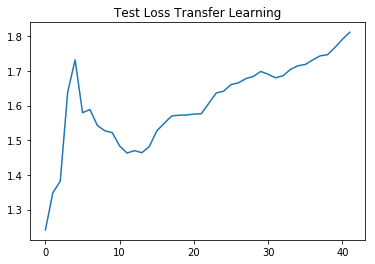

In [94]:
plt.title("Test Loss Transfer Learning")
plt.plot(test_loss_transfer)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [70]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

loaders_transfer['train'].dataset.classes[:5]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute']

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience! 

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [75]:
from PIL import Image
import torchvision.transforms as transforms
import os

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    if os.path.isfile(img_path):
        img = load_input_image(img_path)
        model = model.cpu()
        model.eval()
        idx = torch.argmax(model(img))
        return class_names[idx]

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: ./images/Welsh_springer_spaniel_08203.jpg, 	 predition breed: Welsh springer spaniel
image_file_name: ./images/Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
image_file_name: ./images/Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images/Brittany_02625.jpg, 	 predition breed: Brittany
image_file_name: ./images/Labrador_retriever_06449.jpg, 	 predition breed: Flat-coated retriever
image_file_name: ./images/American_water_spaniel_00648.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images/sample_dog_output.png, 	 predition breed: Italian greyhound
image_file_name: ./images/.ipynb_checkpoints, 	 predition breed: None
image_file_name: ./images/Labrador_retriever_06455.jpg, 	 predition breed: Chesapeake bay retriever


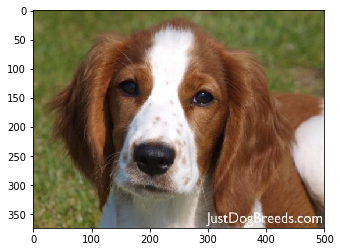

Dogs Detected!
It looks like a Welsh springer spaniel


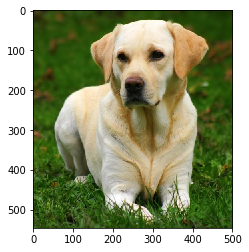

Dogs Detected!
It looks like a Labrador retriever


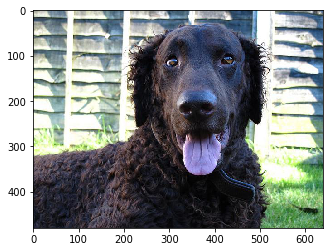

Dogs Detected!
It looks like a Curly-coated retriever


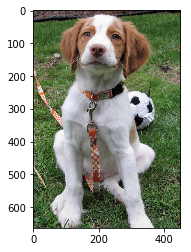

Dogs Detected!
It looks like a Brittany


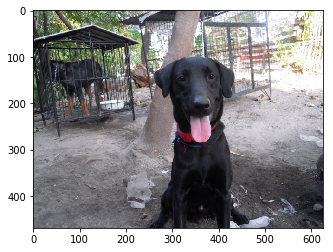

Dogs Detected!
It looks like a Flat-coated retriever


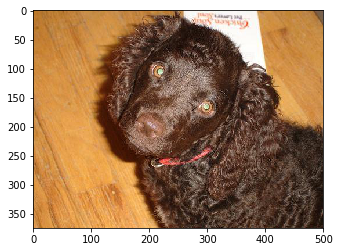

Dogs Detected!
It looks like a Curly-coated retriever


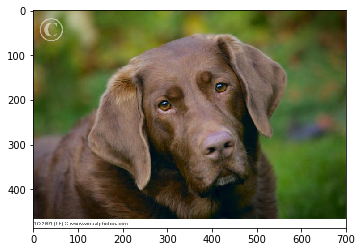

Dogs Detected!
It looks like a Chesapeake bay retriever


In [77]:
import os
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        if dog_detector(img_path) is True:

            prediction = predict_breed_transfer(model_transfer, class_names, img_path)
            print("Dogs Detected!\nIt looks like a {0}".format(prediction))  
        elif face_detector(img_path) > 0:
            prediction = predict_breed_transfer(model_transfer, class_names, img_path)
            print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
        else:
            print("Error! Can't detect anything..")

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ (Three possible points for improvement):

Alright, finally got more than 60% accuracy :). So let me first talk about my journey to 60%

At first i used 10 epochs and the accuracy was 65%. But when the images were run i got wrong prediction. I then ran the code for 15 epochs which gave me 71% accuracy. This was better but still predicted the breed for some dogs wrong. Finally, i set the epochs to 20. This time i got the 74% accuracy. Though this is not much improvement, this timw the predictions were lot better than i expected.

So increasing the number of epochs increase the acuuracy of prediction.

I used the ResNet model hoping to explore the different models. But VGG16 with the modifications in the number of convolution layers input and output channels will increase the prediction.

There is also a need for larger datasets for the dogs and humans for better prediction. As we know more training sets leads to better model. Also the image augmentations will improve the model prediction.

Hyper-parameter tunings: weight initializings, learning rates, drop-outs, batch_sizes, and optimizers will be helpful to improve performances.

['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg'
 '/data/lfw/Donald_Carty/Donald_Carty_0001.jpg'
 '/data/lfw/Barry_Switzer/Barry_Switzer_0001.jpg']


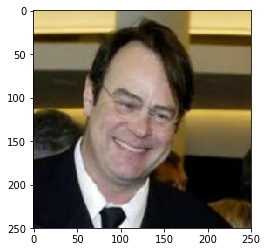

Hello, human!
If you were a dog..You may look like a Basenji


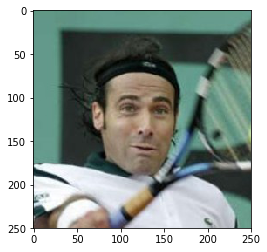

Hello, human!
If you were a dog..You may look like a Bull terrier


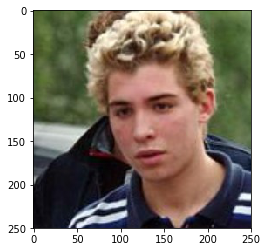

Hello, human!
If you were a dog..You may look like a Australian cattle dog


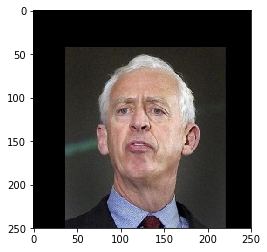

Hello, human!
If you were a dog..You may look like a Basenji


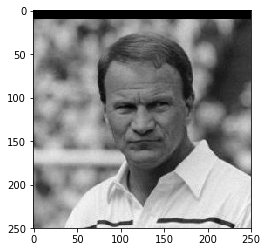

Hello, human!
If you were a dog..You may look like a Basenji


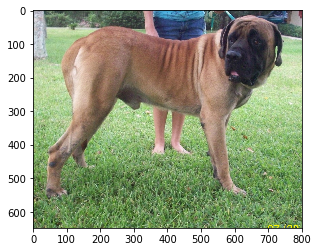

Dogs Detected!
It looks like a Bullmastiff


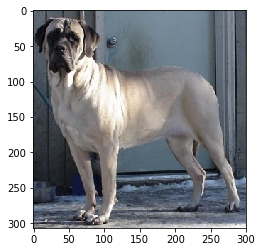

Dogs Detected!
It looks like a Bullmastiff


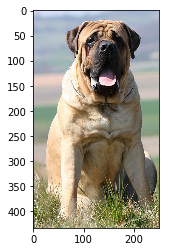

Dogs Detected!
It looks like a Bullmastiff


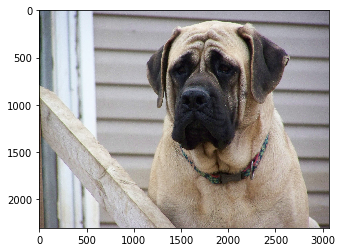

Dogs Detected!
It looks like a Mastiff


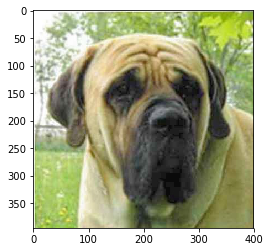

Dogs Detected!
It looks like a Bullmastiff


In [78]:
import numpy as np
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))
print(human_files[:5])
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)